# DEEP LEARNING CLASSIFIER

Packages needed

In [79]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers
from keras import initializers
from keras.layers import Activation, Dense
from keras.initializers import glorot_normal, he_normal
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

#### Load the data

Two functions to load the data:

- dataframe_normal: loads the dataset
- dataframe_normal_augmentation: loads the dataset with the interpolated data, the dataset with missing data and generates a noisy dataset. Then concatenates the three.


In [80]:
seed = 7
np.random.seed(seed)
def dataframe_normal():
    file = 'c:/users/Anana/Desktop/Ana/sensores/data/SSST/work_main_complete.csv'
    # load dataset
    dataframe = pd.read_csv(file)
    dataframe = dataframe[['label','HRbias','BRbias','HRbiasV','BRbiasV','deltaHRbias','deltaBRbias', 'neu',  'hap']]
    dataframe = dataframe.dropna().reset_index(drop=True)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    dataset = dataframe.values
    # split into input (X) and output (Y) variables
    X = dataset[1:,1:].astype(float)
    Y = dataset[1:,0]

    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    target_names = ['calm', 'stress']

    nTrain=int(0.7*len(X))
    X_train = X[:nTrain,:]
    y_train = encoded_Y[:nTrain]
    X_test = X[nTrain:,:]
    y_test = encoded_Y[nTrain:]


    X_std_train = np.nan_to_num(X_train)
    X_std_test = np.nan_to_num(X_test)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaledX_train = scaler.fit_transform(X_std_train)
    X_train = StandardScaler().fit_transform(rescaledX_train)
    rescaledX_test = scaler.fit_transform(X_std_test)
    X_test = StandardScaler().fit_transform(rescaledX_test)

    return X_train, y_train, X_test, y_test

######################################################################################
# DATA FRAME DATA AUGMENTATION

def dataframe_data_augmentation():
    file = 'c:/users/Anana/Desktop/Ana/sensores/data/SSST/work_main_complete.csv'
    file1 = 'c:/users/Anana/Desktop/Ana/sensores/data/SSST/work_main_complete_zeros.csv'

    # load dataset
    dataframe = pd.read_csv(file)
    dataframe1 = pd.read_csv(file1)
    dataframe1 = dataframe1.fillna(value=0)
    dataframe = dataframe[['label','HRbias','BRbias','HRbiasV','BRbiasV','deltaHRbias','deltaBRbias', 'neu',  'hap']]
    dataframe1 = dataframe1[['label','HRbias','BRbias','HRbiasV','BRbiasV','deltaHRbias','deltaBRbias', 'neu',  'hap']]
    dataframe2 = pd.DataFrame()
    dataframe2['label'] = dataframe['label']

    for col in ['HRbias','BRbias','HRbiasV','BRbiasV','deltaHRbias','deltaBRbias', 'neu',  'hap']:
        new_col = []
        noise = 0.1*np.random.uniform(-1,1,len(dataframe[col]))
        for i, val in enumerate(dataframe[col]):
            new_col.append(val+noise[i])
        dataframe2[col] = new_col    
            
    to_join = [dataframe, dataframe1, dataframe2]
    df = pd.concat(to_join)
    df = df.dropna().reset_index(drop=True)
    df = df.sample(frac=1).reset_index(drop=True)

    dataset = df.values

    # split into input (X) and output (Y) variables
    X = dataset[1:,1:].astype(float)
    Y = dataset[1:,0]

    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y) 

    nTrain=int(0.7*len(X))
    X_train = X[:nTrain,:]
    y_train = encoded_Y[:nTrain]
    X_test = X[nTrain:,:]
    y_test = encoded_Y[nTrain:]


    X_std_train = np.nan_to_num(X_train)
    X_std_test = np.nan_to_num(X_test)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaledX_train = scaler.fit_transform(X_std_train)
    X_train = StandardScaler().fit_transform(rescaledX_train)
    rescaledX_test = scaler.fit_transform(X_std_test)
    X_test = StandardScaler().fit_transform(rescaledX_test)

    return X_train, y_train, X_test, y_test

To plot and see the results

In [81]:
def plot_history(history):
    plt.figure(figsize=(20,10))

    plt.subplot(221)
    plt.plot(history.history['acc'],'orange')
    plt.plot(history.history['val_acc'],'crimson')
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(222)
    plt.plot(history.history['loss'],'orange')
    plt.plot(history.history['val_loss'],'crimson')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### CREATE THE MODEL

The model here:

- 3 hidden layers with 200 neurons and batch normalization before the ReLU
- 1 output sigmoid layer
- dropout between each layer
- He initialization
- Adam as optimizer
- learning rate and dropout rate are passed as parameters


In [82]:
def create_model(lr,reg):
    
    model = Sequential()
    model.add(Dense(200, input_dim=8, kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(reg))
    model.add(Dense(200, kernel_initializer=he_normal()))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(reg))
    model.add(Dense(200, kernel_initializer=he_normal(), activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(reg))
    model.add(Dense(1, kernel_initializer=he_normal(), activation='sigmoid'))
    optimizer = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

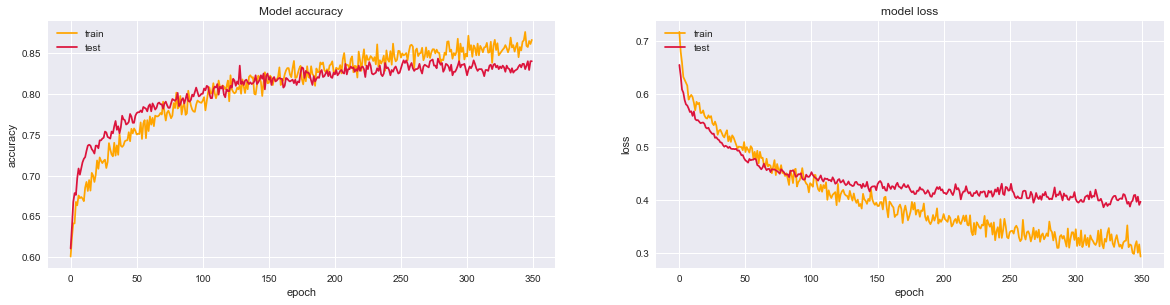

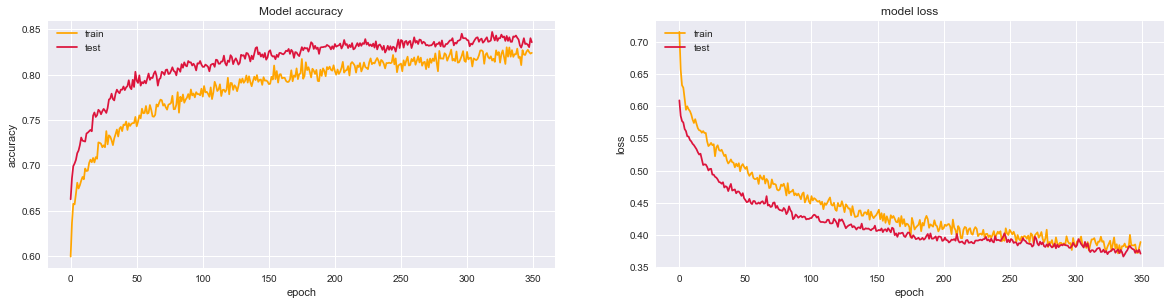

In [83]:
target_names = ['calm', 'stress']
X_train, y_train, X_test, y_test = dataframe_normal()
X_trainDA, y_trainDA, X_testDA, y_testDA = dataframe_data_augmentation()

# model trained with simple data        
model = create_model(0.0009,0.32)
history = model.fit(X_train, y_train, batch_size=50, epochs=350,shuffle=True, verbose=0, validation_data=(X_test, y_test))
plot_history(history)

#model trained with data augmentaiton
modelDA = create_model(0.0009,0.3)
historyDA = modelDA.fit(X_trainDA, y_trainDA, batch_size=50, epochs=350,shuffle=True, verbose=0, validation_data=(X_testDA, y_testDA))
plot_history(historyDA)

### Evaluate with normal dataset

Normal: Test loss: 0.396224871374 
 Test accuracy: 0.839784946237
Normal: Train loss: 0.165844571288 
 Train accuracy: 0.951612903281
Confusion matrix, without normalization
[[331  74]
 [ 75 450]]


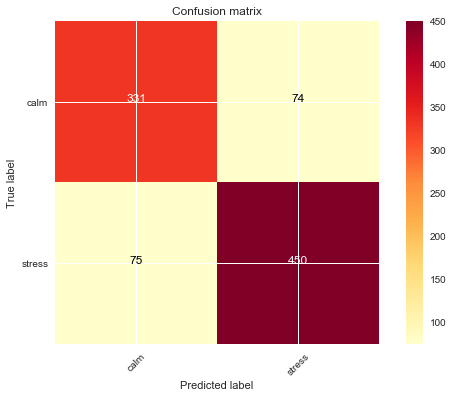

In [84]:
prediction = model.predict(X_test)
y_pred = np.empty([len(prediction)], dtype=int)
for i,value in enumerate(prediction):
    if value>0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

score_test = model.evaluate(X_test, y_test, verbose=0)
score_train = model.evaluate(X_train, y_train, verbose=0)

print('Normal: Test loss:', score_test[0],'\n Test accuracy:', score_test[1])
print('Normal: Train loss:', score_train[0],'\n Train accuracy:', score_train[1])

cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=False,
                          title='Confusion matrix')

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction)
roc_auc = auc(false_positive_rate, true_positive_rate)

### Evaluate with augmented dataset

Normal: Test loss: 0.422345528236 
 Test accuracy: 0.819526627219
Normal: Train loss: 0.236260642656 
 Train accuracy: 0.915010570673
Confusion matrix, without normalization
[[708 197]
 [169 954]]


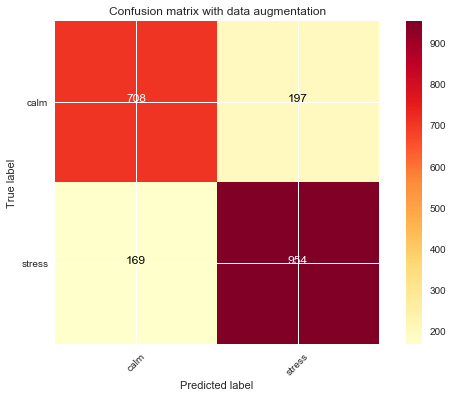

In [23]:
predictionDA = modelDA.predict(X_testDA)
y_predDA = np.empty([len(predictionDA)], dtype=int)
for i,value in enumerate(predictionDA):
    if value>0.5:
        y_predDA[i] = 1
    else:
        y_predDA[i] = 0

score_testDA = modelDA.evaluate(X_testDA, y_testDA, verbose=0)
score_trainDA = modelDA.evaluate(X_trainDA, y_trainDA, verbose=0)

print('Normal: Test loss:', score_testDA[0],'\n Test accuracy:', score_testDA[1])
print('Normal: Train loss:', score_trainDA[0],'\n Train accuracy:', score_trainDA[1])

cnf_matrixDA = confusion_matrix(y_testDA, y_predDA)
plot_confusion_matrix(cnf_matrixDA, classes=target_names, normalize=False,
                          title='Confusion matrix with data augmentation')
plt.show()

false_positive_rateDA, true_positive_rateDA, thresholdsDA = roc_curve(y_testDA, predictionDA)
roc_aucDA = auc(false_positive_rateDA, true_positive_rateDA)

### Compare both and the SVM

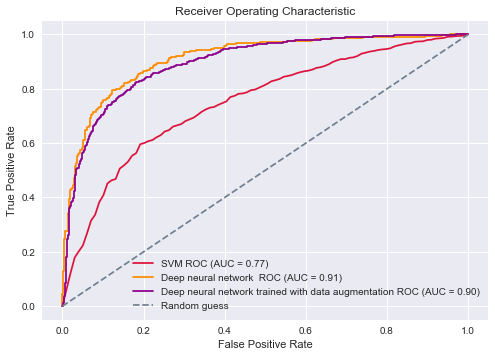

In [25]:

#Load the results for SVM
m_SVM = pd.read_csv('C:/Users/anana/Desktop/Ana/sensores/results/resultadosStandford/VERDAD/SVM/m.csv', delimiter = ',')
mean_fpr = m_SVM['mean_fpr'].values
mean_tpr = m_SVM['mean_tpr'].values

plt.plot(mean_fpr, mean_tpr, color='crimson',
         label='SVM ROC (AUC = 0.77)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate, true_positive_rate, 'darkorange',
label='Deep neural network  ROC (AUC = %0.2f)' % roc_auc)

plt.plot(false_positive_rateDA, true_positive_rateDA, 'darkmagenta',
label='Deep neural network trained with data augmentation ROC (AUC = %0.2f)' % roc_aucDA)

plt.plot([0,1],[0,1],color='slategray',linestyle='--', label = 'Random guess')
plt.legend(loc='lower right')



plt.show()

## DROPPING NOT STRESSED PEOPLE

In [41]:
file = 'c:/users/Anana/Desktop/Ana/sensores/data/SSST/work_main_complete.csv'
# load dataset
dataframe = pd.read_csv(file)
dataframe = dataframe[['id','label','HRbias','BRbias','HRbiasV','BRbiasV','deltaHRbias','deltaBRbias', 'neu',  'hap']]

stats_mean = dataframe.groupby(['id','label']).mean().unstack(0)
stats_std =  dataframe.groupby(['id','label']).std().unstack(0)  

In [28]:
ids_mean = [2,3,6,7,9,10,13,15,16,17,18,20,21,22,23,24,26,27,28,29,30,31,33,34,35,36]
ids_std = [6,13,14,15,16,17,21,22]
ids_2 = [6,7,9,10,11,15,16,17,18,20,21,22,23,24,26,27,28,29,30,31,33,34,35,36]

def dataframe_normal(ids):
    file = 'c:/users/Anana/Desktop/Ana/sensores/data/SSST/work_main_complete.csv'
    # load dataset
    dataframe0 = pd.read_csv(file)
    dataframe = pd.DataFrame(columns=list(dataframe0))
    for i in ids:
        aux = dataframe0.loc[dataframe0['id']==i]
        dataframe = dataframe.append(aux)
        
    dataframe = dataframe[['label','HRbias','BRbias','HRbiasV','BRbiasV','deltaHRbias','deltaBRbias', 'neu',  'hap']]
    dataframe = dataframe.dropna().reset_index(drop=True)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    dataset = dataframe.values
    # split into input (X) and output (Y) variables
    X = dataset[1:,1:].astype(float)
    Y = dataset[1:,0]

    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    target_names = ['calm', 'stress']

    nTrain=int(0.7*len(X))
    X_train = X[:nTrain,:]
    y_train = encoded_Y[:nTrain]
    X_test = X[nTrain:,:]
    y_test = encoded_Y[nTrain:]


    X_std_train = np.nan_to_num(X_train)
    X_std_test = np.nan_to_num(X_test)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaledX_train = scaler.fit_transform(X_std_train)
    X_train = StandardScaler().fit_transform(rescaledX_train)
    rescaledX_test = scaler.fit_transform(X_std_test)
    X_test = StandardScaler().fit_transform(rescaledX_test)

    return X_train, y_train, X_test, y_test

### Dropping those with a mean that doesn't change

Normal: Test loss: 0.228579463774 
 Test accuracy: 0.929655172496
Normal: Train loss: 0.219615335809 
 Train accuracy: 0.930218805194
Confusion matrix, without normalization
[[288  26]
 [ 25 386]]


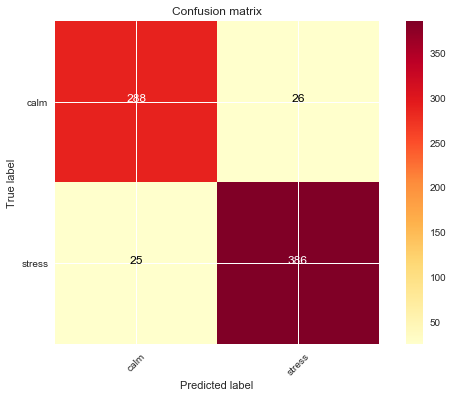

In [30]:
X_trainm, y_trainm, X_testm, y_testm = dataframe_normal(ids_mean)

predictionm = model.predict(X_testm)
y_predm = np.empty([len(predictionm)], dtype=int)
for i,value in enumerate(predictionm):
    if value>0.5:
        y_predm[i] = 1
    else:
        y_predm[i] = 0

score_testm = model.evaluate(X_testm, y_testm, verbose=0)
score_trainm = model.evaluate(X_trainm, y_trainm, verbose=0)

print('Normal: Test loss:', score_testm[0],'\n Test accuracy:', score_testm[1])
print('Normal: Train loss:', score_trainm[0],'\n Train accuracy:', score_trainm[1])

cnf_matrixm = confusion_matrix(y_testm, y_predm)
plot_confusion_matrix(cnf_matrixm, classes=target_names, normalize=False,
                          title='Confusion matrix')

false_positive_ratem, true_positive_ratem, thresholdsm = roc_curve(y_testm, predictionm)
roc_aucm = auc(false_positive_ratem, true_positive_ratem)

### Dropping those with an std that doesn't change

Normal: Test loss: 0.228463817436 
 Test accuracy: 0.918454935878
Normal: Train loss: 0.210170159701 
 Train accuracy: 0.924354243762
Confusion matrix, without normalization
[[ 86  11]
 [  8 128]]


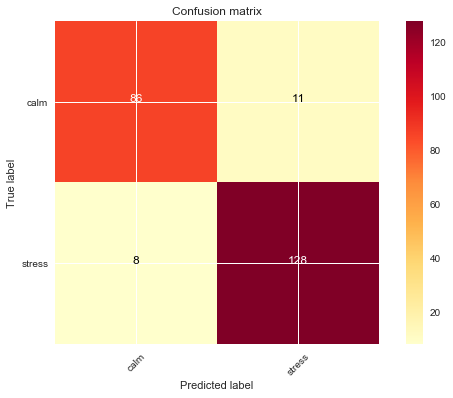

In [31]:
X_trains, y_trains, X_tests, y_tests= dataframe_normal(ids_std)

predictions = model.predict(X_tests)
y_preds = np.empty([len(predictions)], dtype=int)
for i,value in enumerate(predictions):
    if value>0.5:
        y_preds[i] = 1
    else:
        y_preds[i] = 0

score_tests = model.evaluate(X_tests, y_tests, verbose=0)
score_trains = model.evaluate(X_trains, y_trains, verbose=0)

print('Normal: Test loss:', score_tests[0],'\n Test accuracy:', score_tests[1])
print('Normal: Train loss:', score_trains[0],'\n Train accuracy:', score_trains[1])

cnf_matrixs = confusion_matrix(y_tests, y_preds)
plot_confusion_matrix(cnf_matrixs, classes=target_names, normalize=False,
                          title='Confusion matrix')

false_positive_rates, true_positive_rates, thresholdss = roc_curve(y_tests, predictions)
roc_aucs = auc(false_positive_rates, true_positive_rates)

### Dropping those with at least two changes

Normal: Test loss: 0.198449888811 
 Test accuracy: 0.939157566303
Normal: Train loss: 0.235595423915 
 Train accuracy: 0.921634293409
Confusion matrix, without normalization
[[250  22]
 [ 17 352]]


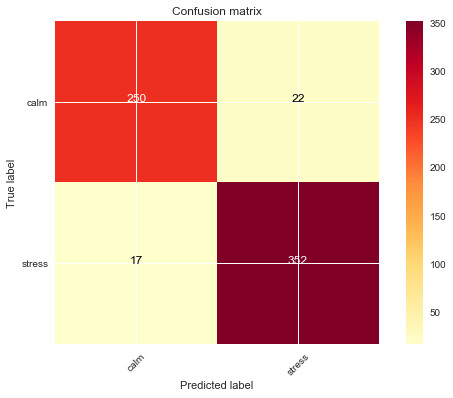

In [32]:
X_train2, y_train2, X_test2, y_test2= dataframe_normal(ids_2)

prediction2 = model.predict(X_test2)
y_pred2 = np.empty([len(prediction2)], dtype=int)
for i,value in enumerate(prediction2):
    if value>0.5:
        y_pred2[i] = 1
    else:
        y_pred2[i] = 0

score_test2 = model.evaluate(X_test2, y_test2, verbose=0)
score_train2 = model.evaluate(X_train2, y_train2, verbose=0)

print('Normal: Test loss:', score_test2[0],'\n Test accuracy:', score_test2[1])
print('Normal: Train loss:', score_train2[0],'\n Train accuracy:', score_train2[1])

cnf_matrix2 = confusion_matrix(y_test2, y_pred2)
plot_confusion_matrix(cnf_matrix2, classes=target_names, normalize=False,
                          title='Confusion matrix')

false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_test2, prediction2)
roc_auc2 = auc(false_positive_rate2, true_positive_rate2)

### Which features affect more?

In [92]:
def dataframe_normal(features):
    file = 'c:/users/Anana/Desktop/Ana/sensores/data/SSST/work_main_complete.csv'
    # load dataset
    dataframe = pd.read_csv(file)
    dataframe[features]=0
    dataframe = dataframe[['label','HRbias','BRbias','HRbiasV','BRbiasV','deltaHRbias','deltaBRbias', 'neu',  'hap']]
    dataframe = dataframe.dropna().reset_index(drop=True)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    dataset = dataframe.values
    # split into input (X) and output (Y) variables
    X = dataset[1:,1:].astype(float)
    Y = dataset[1:,0]

    encoder = LabelEncoder()
    encoder.fit(Y)
    encoded_Y = encoder.transform(Y)
    target_names = ['calm', 'stress']

    nTrain=int(0.7*len(X))
    X_train = X[:nTrain,:]
    y_train = encoded_Y[:nTrain]
    X_test = X[nTrain:,:]
    y_test = encoded_Y[nTrain:]


    X_std_train = np.nan_to_num(X_train)
    X_std_test = np.nan_to_num(X_test)
    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaledX_train = scaler.fit_transform(X_std_train)
    X_train = StandardScaler().fit_transform(rescaledX_train)
    rescaledX_test = scaler.fit_transform(X_std_test)
    X_test = StandardScaler().fit_transform(rescaledX_test)

    return X_train, y_train, X_test, y_test

In [98]:
features = [['hap','neu'],['HRbias', 'deltaHRbias', 'HRbiasV','hap','neu'],
            ['BRbias', 'deltaBRbias', 'BRbiasV','hap','neu'],
            ['HRbias', 'deltaHRbias', 'HRbiasV','BRbias', 'deltaBRbias', 'BRbiasV'],
            [ 'deltaHRbias', 'HRbiasV', 'deltaBRbias', 'BRbiasV', 'neu', 'hap']]

#features = ['HRbias', 'deltaHRbias', 'HRbiasV','hap,'neu']
#features = ['BRbias', 'deltaBRbias', 'BRbiasV','hap,'neu']
#features = ['HRbias', 'deltaHRbias', 'HRbiasV','BRbias', 'deltaBRbias', 'BRbiasV']
#features = [ 'deltaHRbias', 'HRbiasV', 'deltaBRbias', 'BRbiasV', 'neu', 'hap']

scores = pd.DataFrame()
j = 0
for feat in features:
    X_train, y_train, X_test, y_test= dataframe_normal(feat)
    prediction = model.predict(X_test)
    y_pred = np.empty([len(prediction)], dtype=int)
    for i,value in enumerate(prediction):
        if value>0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0

    score_test = model.evaluate(X_test, y_test, verbose=0)
    score_train = model.evaluate(X_train, y_train, verbose=0)
    print(score_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction)
    scores[j] = [feat,score_test,score_train,false_positive_rate, true_positive_rate]


[0.49876565317953786, 0.7817204301075269]
[0.81582108415583132, 0.57741935483870965]
[0.78795024810298797, 0.58064516129032262]
[0.69724748967796246, 0.5741935483870968]
[0.7602846666689842, 0.5956989247311828]


In [ ]:
scores

C:\Users\anana\Anaconda3\envs\py35new\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


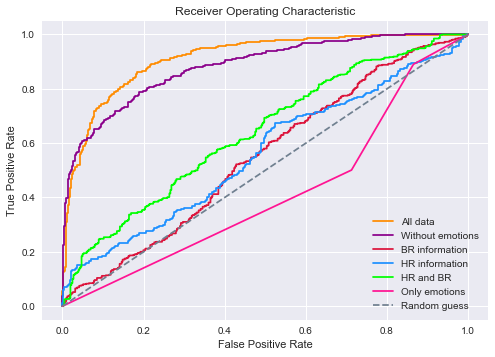

In [90]:
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate, true_positive_rate, 'darkorange',
label='All data')

plt.plot(scores[0][3], scores[0][4], 'darkmagenta',
label='Without emotions')

plt.plot(scores[1][3], scores[1][4], 'crimson',
label='BR information')

plt.plot(scores[2][3], scores[2][4], 'dodgerblue',
label='HR information')


plt.plot(scores[4][3], scores[4][4], 'lime',
label='HR and BR')

plt.plot(scores[3][3], scores[3][4], 'deeppink',
label='Only emotions')


plt.plot([0,1],[0,1],color='slategray',linestyle='--', label = 'Random guess')

plt.legend(loc='lower right')


plt.show()